# Cloudbutton geospatial use case: 3D fuel mapping for wildfire risk assessment


In [1]:
import datetime
# from sklearn.naive_bayes import GaussianNB
# from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import scale, StandardScaler
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
# from shapely.geometry import mapping
from IPython.display import Image
# from IPython.core.display import HTML
# from shapely.geometry import mapping
# import rasterio as rio
# from sklearn.pipeline import Pipeline
# from rasterio.mask import mask
# from rasterio.plot import show
# from rasterio.merge import merge
# from rasterio.plot import show
# from rasterio.plot import show_hist
# from rasterio.windows import Window
# from rasterio.plot import reshape_as_raster
# from rasterio.plot import reshape_as_image
from lithops.storage import Storage
import matplotlib.pyplot as plt
# import geopandas as gpd
import pandas as pd
import numpy as np
import lithops
import pathlib
# import shapely
import shutil
# import pickle
import subprocess
# import concurrent.futures
# import joblib
# import gdal
# import earthpy as ep
# import earthpy.spatial as es
# import time
# import glob
# import ogr
import os
# import io
# import pdal
# import xarray as xr
import json
# from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
DIR_TO_EXECT = "" # 20GB/10GB/2GB/1GB/512M/B256MB/128MB
DATA_BUCKET = 'objects-geospatial-wildfirerisk-0'
INPUT_DATA_PREFIX = f'data-example/{DIR_TO_EXECT}' # Modified

In [3]:
# !export LITHOPS_CONFIG_FILE = "/home/aitor/Projects/lithops-github/lithops/.lithops_config"
# os.environ['LITHOPS_CONFIG_FILE'] = '/home/aitor/Projects/lithops-github/lithops/.lithops_config'

Experiment parameters


In [4]:
FCC_WINDOW = 3
FCC_BREAKPOINT = 0.01

---
Upload dataset
---


In [5]:
LOCAL_INPUT_DIR = f'./data/{DIR_TO_EXECT}'

In [6]:
storage = Storage()

In [7]:
bucket_objects = storage.list_keys(bucket=DATA_BUCKET)
for file_name in os.listdir(LOCAL_INPUT_DIR):
    key = os.path.join(INPUT_DATA_PREFIX, file_name)    # Added
    if key not in bucket_objects:   # Changed: if file_name not in bucket_objects:
        with open(os.path.join(LOCAL_INPUT_DIR, file_name), 'rb') as file:
            print(f'Uploading {key}...')
            data = file.read()
            storage.put_object(bucket=DATA_BUCKET, key=key, body=data)
            print('Ok!')
    else:   # Added
        print(f'It is already uploaded: {key}...')   # Added
'''
for file_name in os.listdir(LOCAL_INPUT_DIR):
    if file_name not in bucket_objects:
        key = os.path.join(INPUT_DATA_PREFIX, file_name)
        with open(os.path.join(LOCAL_INPUT_DIR, file_name), 'rb') as file:
            print(f'Uploading {key}...')
            data = file.read()
            storage.put_object(bucket=DATA_BUCKET, key=key, body=data)
            print('Ok!')
# storage.put_object()
'''

It is already uploaded: data-example/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_278-4470_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_650-4434_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_742-4404_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_748-4414_ORT-CLA-RGB.laz...


"\nfor file_name in os.listdir(LOCAL_INPUT_DIR):\n    if file_name not in bucket_objects:\n        key = os.path.join(INPUT_DATA_PREFIX, file_name)\n        with open(os.path.join(LOCAL_INPUT_DIR, file_name), 'rb') as file:\n            print(f'Uploading {key}...')\n            data = file.read()\n            storage.put_object(bucket=DATA_BUCKET, key=key, body=data)\n            print('Ok!')\n# storage.put_object()\n"

---
Calculte DEM, DSM and CHM
---


In [8]:
def calculate_models(obj, storage):
    import pdal
    from osgeo import gdal
    from scipy import ndimage

    # Create temporary file paths
    tmp_path_prefix = '/tmp/geo/'
    if os.path.exists(tmp_path_prefix):
        shutil.rmtree(tmp_path_prefix)
    for subpath in ['dsm', 'dem', 'chm', 'aspect', 'slope', 'fcc']:
        os.makedirs(os.path.join(tmp_path_prefix, subpath), exist_ok=True)

    las_tile_filename = pathlib.Path(obj.key).name
    tile_key = pathlib.Path(obj.key).stem

    # Save obj to file
    data = obj.data_stream.read()
    input_file_path = os.path.join(tmp_path_prefix, las_tile_filename)
    with open(input_file_path, 'wb') as file:
        file.write(data)

    # DSM pipeline
    dsm_file_path = os.path.join(tmp_path_prefix, 'dsm', tile_key + '.gtiff')
    dsm_pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": f"{input_file_path}",
                "spatialreference": "EPSG:25830"
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:25830",
                "out_srs": "EPSG:25830"
            },
            {
                "type": "filters.outlier",
                "method": "radius",
                "radius": 1.0,
                "min_k": 4
            },
            {
                "type": "filters.range",
                # Classification equals 2 (corresponding to noise points in LAS).
                "limits": "Classification![7:7]"
            },
            {
                "type": "filters.range",
                "limits": "returnnumber[1:1]"
            },
            {
                "type": "writers.gdal",
                "gdaldriver": "GTiff",
                "nodata": "-9999",
                "output_type": "max",
                "resolution": 1,
                "filename": f"{dsm_file_path}"
            }
        ]
    }
    dsm_pipeline_json_str = json.dumps(dsm_pipeline_json, indent=4)
    pipeline = pdal.Pipeline(dsm_pipeline_json_str)
    pipeline.validate()
    pipeline.loglevel = 8
    print('Executing DSM pipeline...')
    result = pipeline.execute()
    print(result)

    # DEM pipeline
    dem_file_path = os.path.join(tmp_path_prefix, 'dem', tile_key + '.gtiff')
    dem_pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": f"{input_file_path}",
                "spatialreference": "EPSG:25830"
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:25830",
                "out_srs": "EPSG:25830"
            },
            {
                "type": "filters.assign",
                "assignment": "Classification[:]=0"
            },
            {
                "type": "filters.elm"
            },
            {
                "type": "filters.outlier",
                "method": "radius",
                "radius": 1.0,
                "min_k": 4
            },
            {

                "type": "filters.smrf",
                "ignore": "Classification[7:7]",
                "slope": 0.2,
                "window": 16,
                "threshold": 0.45,
                "scalar": 1.2
            },
            {
                "type": "filters.range",
                # Classification equals 2 (corresponding to ground in LAS).
                "limits": "Classification[2:2]",
            },
            {
                "type": "writers.gdal",
                "gdaldriver": "GTiff",
                "nodata": "-9999",
                "output_type": "max",
                "resolution": 1,
                "filename": f"{dem_file_path}"
            }
        ]
    }
    dem_pipeline_json_str = json.dumps(dem_pipeline_json, indent=4)
    pipeline = pdal.Pipeline(dem_pipeline_json_str)
    pipeline.validate()  # Check if json options are good
    pipeline.loglevel = 8
    print('Executing DEM pipeline...')
    result = pipeline.execute()
    print(result)

    # calculate CHM
    chm_file_path = os.path.join(tmp_path_prefix, 'chm', tile_key + '.tiff')
    cmd = ['gdal_calc.py', '-A', dem_file_path, '-B', dsm_file_path,
           '--calc="B-A"', '--NoDataValue=0', '--outfile', chm_file_path]
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate aspect
    aspect_file_path = os.path.join(tmp_path_prefix, 'aspect', tile_key + '.tiff')
    cmd = ['gdaldem', 'aspect', dem_file_path, aspect_file_path, '-compute_edges']
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate slope
    slope_file_path = os.path.join(tmp_path_prefix, 'slope', tile_key + '.tiff')
    cmd = ['gdaldem', 'slope', dem_file_path, slope_file_path, '-compute_edges']
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate FCC
    in_ds = gdal.Open(dem_file_path)
    rows = in_ds.RasterYSize
    cols = in_ds.RasterXSize
    in_band = in_ds.GetRasterBand(1)
    data = in_band.ReadAsArray(0, 0, cols, rows).astype(np.float)
    data[data > FCC_BREAKPOINT] = 1
    data[data <= FCC_BREAKPOINT] = 0

    # Computing fraction on the whole raster through a moving window.
    def _compute_fraction(array):
        nveg = np.sum(array == 1)
        total = len(array)
        out = (nveg/total)*100
        return(out)

    TCC = ndimage.generic_filter(data, _compute_fraction, size=FCC_WINDOW)

    gtiff_driver = gdal.GetDriverByName("GTiff")
    fcc_file_path = os.path.join(tmp_path_prefix, 'fcc', tile_key + '.tiff')
    out_ds = gtiff_driver.Create(fcc_file_path, cols, rows, 1, in_band.DataType)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())

    out_band = out_ds.GetRasterBand(1)
    out_band.WriteArray(TCC)
    # out_ds.BuildOverviews("Average", [2, 4, 8, 16, 32])
    out_ds.FlushCache()
    del in_ds, out_ds

    outputs = [dsm_file_path, dem_file_path, chm_file_path,
               aspect_file_path, slope_file_path, fcc_file_path]
    for output_path in outputs:
        if os.path.exists(output_path):
            with open(output_path, 'rb') as output_file:
                data = output_file.read()
                cos_key = output_path.replace(tmp_path_prefix, '')
                storage.put_object(bucket=DATA_BUCKET, key=cos_key, body=data)
        else:
            print(f'Failed to upload {output_path}')

    out = subprocess.check_output(['find', '/tmp/geo/'])
    return out

In [9]:
fexec = lithops.FunctionExecutor(monitoring='rabbitmq')

2022-05-25 12:35:36,545 [INFO] lithops.config -- Lithops v2.6.0
2022-05-25 12:35:36,596 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-05-25 12:35:36,599 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-de - Namespace: my-geospatial-wildfirerisk_foundry-geospatial-wildfirerisk-0


In [10]:
fexec.map(calculate_models, f'cos://{DATA_BUCKET}/{INPUT_DATA_PREFIX}')

2022-05-25 12:35:36,630 [INFO] lithops.invokers -- ExecutorID f85779-0 | JobID M000 - Selected Runtime: sararl27/lithops-ibm_cf-runtime-3.9:0.1 - 2048MB
2022-05-25 12:35:41,686 [INFO] lithops.invokers -- ExecutorID f85779-0 | JobID M000 - Starting function invocation: calculate_models() - Total: 6 activations
2022-05-25 12:35:41,702 [INFO] lithops.invokers -- ExecutorID f85779-0 | JobID M000 - View execution logs at C:\Users\saral\AppData\Local\Temp\lithops\logs\f85779-0-M000.log


In [11]:
res = fexec.get_result()

2022-05-25 12:35:42,447 [INFO] lithops.wait -- ExecutorID f85779-0 - Getting results from 6 function activations


    0%|          | 0/6  

2022-05-25 12:38:03,349 [INFO] lithops.executors -- ExecutorID f85779-0 - Cleaning temporary data


In [12]:
# res

In [13]:
for r in res:
    print(r.decode('utf-8').strip())
    print('---')

/tmp/geo/
/tmp/geo/fcc
/tmp/geo/fcc/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff
/tmp/geo/aspect
/tmp/geo/aspect/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff
/tmp/geo/slope
/tmp/geo/slope/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff
/tmp/geo/dem
/tmp/geo/dem/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.gtiff
/tmp/geo/chm
/tmp/geo/chm/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff
/tmp/geo/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.laz
/tmp/geo/dsm
/tmp/geo/dsm/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.gtiff
---
/tmp/geo/
/tmp/geo/chm
/tmp/geo/chm/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff
/tmp/geo/dsm
/tmp/geo/dsm/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.gtiff
/tmp/geo/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.laz
/tmp/geo/aspect
/tmp/geo/aspect/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff
/tmp/geo/slope
/tmp/geo/slope/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff
/tmp/geo/dem
/tmp/geo/dem/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.gtiff
/tmp/geo/fcc
/tmp/geo/fcc/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff
---
/tmp

---
Scalability
---

#### Time

In [14]:
# fexec.futures

In [15]:
fexec.plot(dst="plotS/scalability")

2022-05-25 12:38:05,605 [INFO] lithops.executors -- ExecutorID f85779-0 - Creating execution plots


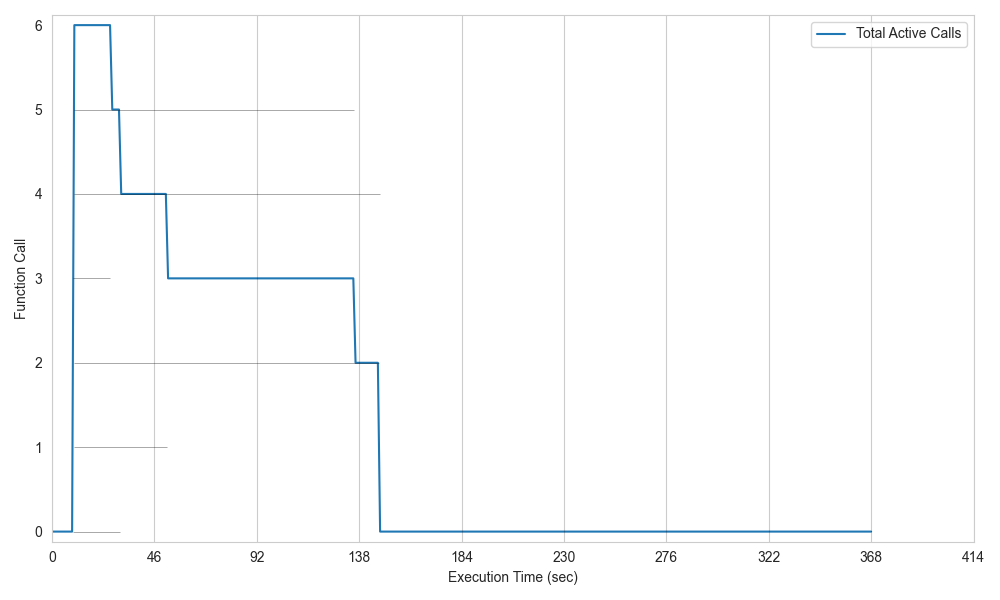

In [16]:
Image(filename="plots/scalability_histogram.png")

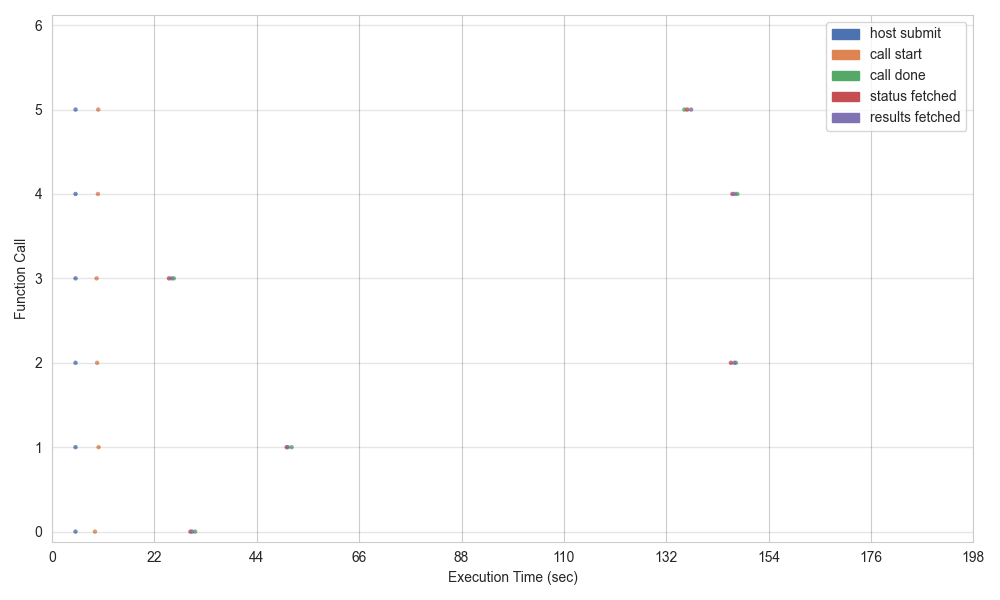

In [17]:
Image(filename="plots/scalability_timeline.png")

#### Throughput

Read

In [18]:
data_size_read = sum(obj['Size'] for obj in storage.list_objects(DATA_BUCKET) if str(obj['Key']).endswith('.laz'))
print(f"Data size: {data_size_read / 1024**2} MiB")

Data size: 43.343241691589355 MiB


Write

In [19]:
data_size_write = sum(obj['Size'] for obj in storage.list_objects(DATA_BUCKET) if str(obj['Key']).endswith('.tiff'))
print(f"Data size: {data_size_write / 1024**2} MiB")

Data size: 301.35498046875 MiB


In [20]:
tstamps = set()
for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])

duration = max(tstamps) - min(tstamps)
print("Duration: " + str(datetime.timedelta(seconds=duration)))

Duration: 0:02:27.257095


In [21]:
throughput_read = data_size_read / duration  # Bytes/second
throughput_write = data_size_write / duration  # Bytes/second

In [22]:
print(f"Read throughput: {throughput_read / 1024**2} MiB/s")
print(f"Write throughput: {throughput_write / 1024**2} MiB/s")

Throughput: 2.046454738084237 MiB/s


#### Cost

In [23]:
def get_process_cost(fexec):
    import pandas as pd
    df = pd.read_csv(fexec.log_path)
    cost = float(df[df["Job_ID"] == "Summary"]["Cost"])
    return cost

In [24]:
fexec.job_summary()

2022-05-25 12:38:07,138 [INFO] lithops.executors -- View log file logs at C:\Users\saral\AppData\Local\Temp\lithops\logs\2022-05-25_12_38_07.csv


In [25]:
pd.read_csv(fexec.log_path)

,Job_ID,Function,Invocations,Memory(MB),AvgRuntime,Cost,CloudObjects
0,M000,calculate_models,6,12288,80.032557,0.016327,
1,Summary,,6,12288,80.032557,0.016327,0


In [26]:
cost_interpolation = get_process_cost(fexec)
print(f"The experiment cost ${cost_interpolation:.4f}.")

The experiment cost $0.0163.
